In [1]:
## Simple setup to run this notebook
import os
import numpy as np
import pandas as pds
from collections import defaultdict

import rdkit
from rdkit.Chem.rdmolops import GetSSSR
from rdkit.Chem.rdmolfiles import MolToSmiles
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, MolFromSmiles

In [2]:
from libTMC.molecular_properties import *

This notebook demonstrates how we calculate the chemical and the molecular properties in Fig. 2 and Fig. 3.

In [3]:
datadf = pds.read_csv('examples.csv').drop(['Unnamed: 0'], axis=1)
datadf.head()

,CSD_ID,TMC-SMILES
0,MAGNEO,CC1(C)C=CC(=N(C(=O)c2ccccc2)->[Pt+2](<-[Cl-])(...
1,QEWKUC,CC(=O)[O-]->[Cd+2]12(<-NCCN->13CCOCC3)(<-NCCN-...
2,JAGNEL,Cc1ccc(N=Nc2n(C)ccn2->[Zn+2](<-O)(<-[Cl-])<-[C...
3,CORVEN,CC(C)(C)P1(CCN23CCP(C(C)(C)C)(C(C)(C)C)->[Re+6...
4,JOCQAV,c1ccc(P2(CN3CP(c4ccccc4)(c4ccccc4)->[RuH2]<-2(...


### Calculate chemical information and molecular properties
- Chemical information: properties that are used in supervised fine-tuning (SFT) prompts
- Molecular properties: properties to differentiate regular and unrealistic TMCs
  
Here we calculate the properties of TMCs and their heavy ligands with more than one heavy atom. To get the `mol` objects of both TMCs and ligands, we first identify TM atoms by examine their atomic numbers, which are hard-coded in `find_all_tms()` and its corresponding sub-functions, `_is_metal()` and `_is_transition_metal()`. Then, we remove the identified TM atoms, which will isolate the single-atom ligands. Finally, we remove these isolated atoms in TMC `mol` with `remove_isolated_atoms()` and the remaining atom graphs will be heavy ligands (which may contain multiple molecules!).
  
1. Transition metal (TM) oxidation states:  
   &emsp; Using `CalcOxidationNumbers()` function, which calculates oxidation states for all atoms in a molecule, from `rdkit.Chem.rdMolDescriptors` module. Then, obtain the calculated `OxidationNumber` property from TM atoms.

2. Number of coordinating atoms, $N_{\mathrm{coord.\ atoms}}$:  
   &emsp; If all redundant and wrong dative bonds (**note**: only metal-ligand connections should be represented as dative bonds in TMC-SMILES) are removed from TMCs, we can simply calculate the coordinating atoms ($N_{\mathrm{coord.\ atoms}}$) by counting dative bonds. This is implemented in `count_coord_atoms()`.  
   &emsp; To identify redundant dative bonds (very occasional, <<5%), we can examine whether the ending atoms of dative bonds are TM atoms.
   
3. TMC and ligand molecular weights:  
   &emsp; There's a simple function, `MolWt()`, in `Descriptor` module. Apply it on TMC `mol` and ligand mol `ligands`.
   
4. Ring information in TMCs and ligands:  
   &emsp; Calculations of ring structures are based on `GetRingInfo()` and `RingInfo` class (in RDKit C++). The <u>*Small Set of Smallest Rings*</u> (SSSR) algorithm is the foundation of these calculations, which can be read [**here**](https://www.rdkit.org/docs/GettingStartedInPython.html#the-sssr-problem) and [**here**](https://www.rdkit.org/docs/GettingStartedInPython.html#ring-information). All eight properties related to rings are computed through `GetRingInfo()`, such as the number of rings $N_{\mathrm{rings}}$, the number of fused rings $N_{\mathrm{fused\ rings}}$, the number of macrocycles $N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$, their corresponding ligand results, and the differences between TMC and ligand for the number of rings and fused rings $\Delta N_{\mathrm{rings}}$ and $\Delta N_{\mathrm{fused\ rings}}$.  
   &emsp; To calculate these properties of ligands, we simply get `RingInfo` from ligand mol `ligands`. To calculate those of TMCs, it's more complicated because we need to consider dative bonds in TMC. Setting `GetSSSR()` parameter `includeDativeBonds` to **True** allows us to count all rings in TMC. The default value of `includeDativeBonds` is **False** in RDKit, so default RDKit calculations always lead to results for ligands. This will be further discussed in next section. Calculation details are described below:
   - *i*. $N_{\mathrm{rings}}$ can be evaluated by `NumRings()` from `RingInfo` (initialized by `GetRingInfo()` on `mol`)
   - *ii*. Fused rings are a subset of rings that share at least one common bond with other rings. Fused rings in `RingInfo` can be identified by calling `isRingFused(<ring_index>)`. Then, we count these fused rings for $N_{\mathrm{fused\ rings}}$. In our script, we collect the indices of fused rings in `get_fused_ring_idx()` and count the length of index list.
   - *iii*. Macrocycles are rings with eight or more atoms. Thus, we summarize the sizes of all rings in `get_all_ring_sizes()` and count the rings which have $>$ 7 atoms.
   - *iv*. $\Delta N_{\mathrm{rings}}$ and $\Delta N_{\mathrm{fused\ rings}}$ are differences of $N_{\mathrm{rings}}$ and $N_{\mathrm{fused\ rings}}$ between TMCs and ligands. There are more rings and fused rings in TMCs than isolated ligands because connected ligand coordinating atoms can form rings with TM centers, while removing the TM atoms will break these rings. Thus, $\Delta N_{\mathrm{rings}}$ and $\Delta N_{\mathrm{fused\ rings}}$ can be regarded as indicators which describe the structural complexity around TM atoms.  
   &emsp; The TMC example in the next section has large $\Delta N_{\mathrm{rings}}$ and $\Delta N_{\mathrm{fused\ rings}}$.

In [4]:
outdict = defaultdict(list)
for csdid, smi in zip(datadf['CSD_ID'], datadf['TMC-SMILES']):
    try:
        mol = MolFromSmiles(smi)
        ## For transition metal (TM) oxidation states
        rdMolDescriptors.CalcOxidationNumbers(mol)
    except:
        print(csdid, 'oxidation state calculation faliure.')
        continue

    """
        Step 1: get TM atom and its index
    """
    tm_indices, tm_atoms = find_all_tms(mol)
    if len(tm_indices)!=1:
        raise ValueError(f'TMC {csdid} not mononuclear!', len(tm_atoms))
    
    num_tms = len(tm_indices)
    tm_idx = tm_indices[0]
    tm = tm_atoms[0]

    """
        S1.5: remove TMs and isolated atoms to get ligands
    """
    emol = EditableMol(mol)
    for idx in sorted(tm_indices, reverse=True):
        emol.RemoveAtom(idx)
    tmp = emol.GetMol()
    removed = remove_isolated_atoms(tmp)
    lsmi = MolToSmiles(removed)
    ligands = MolFromSmiles(lsmi)

    """
        Step 2: get # of coord. atoms (dative bonds)
        (assuming that all redundant dative bonds are removed)
    """
    num_coord = count_coord_atoms(mol)

    """
        Step 3: get TM oxidation number
    """
    tm_oxi = tm.GetPropsAsDict()['OxidationNumber']

    """
        Step 4: get molecular weights
    """
    mw = Descriptors.MolWt(mol)
    lmw = Descriptors.MolWt(ligands)

    """
        Step 5: dealing with rings
    """
    ## Note: dative bonds are not considered in ring by RDKit default!
    ## this setting can be changed by GSSSR (will remain IN-PLACE)
    
    l_ri = ligands.GetRingInfo()
    l_ring_sizes = get_all_ring_sizes(ligands)
    l_fused_indices = get_fused_ring_idx(ligands)
    
    l_num_r = l_ri.NumRings() ## number of small rings
    l_num_fused = len(l_fused_indices) ## number of fused rings
    ## Macrocycles: atom members larger or equal to eight
    l_macro = len([n for n in l_ring_sizes if n>7])

    ## S5.2: TMC rings --> with dative bonds
    try:
        sssr = GetSSSR(mol, includeDativeBonds=True)
    except:
        print(f'{csdid} TMC too complex to count rings')
        continue
    t_ri = mol.GetRingInfo()
    t_ring_sizes = get_all_ring_sizes(mol)
    t_fused_indices = get_fused_ring_idx(mol)
    
    t_num_r = t_ri.NumRings()
    t_num_fused = len(t_fused_indices)
    t_macro = len([n for n in t_ring_sizes if n>7])
    
    outdict['CSD_ID'].append(csdid)
    outdict['TMC-SMILES'].append(smi)
    outdict['Ligand-SMILES'].append(lsmi)
    outdict[r'$N_{\mathrm{coord.\ atoms}}$'].append(num_coord)
    outdict['TM oxidation state'].append(tm_oxi)
    outdict['Molecular weight'].append(mw)
    outdict['Ligand molecular weight'].append(lmw)
    
    outdict[r'$N_{\mathrm{rings}}$'].append(t_num_r)
    outdict[r'$N_{\mathrm{fused\ rings}}$'].append(t_num_fused)
    outdict[r'$N^{\mathrm{ligand}}_{\mathrm{rings}}$'].append(l_num_r)
    outdict[r'$N^{\mathrm{ligand}}_{\mathrm{fused\ rings}}$'].append(l_num_fused)
    ## the change of rings / fused rings between TMCs and ligands
    outdict[r'$\Delta N_{\mathrm{rings}}$'].append(t_num_r-l_num_r)
    outdict[r'$\Delta N_{\mathrm{fused\ rings}}$'].append(t_num_fused-l_num_fused)
    
    outdict[r'$N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$'].append(t_macro)
    outdict[r'$N_{\mathrm{macrocycles}}^{\mathrm{ligand}}$'].append(l_macro)
    outdict['TMs'].append(num_tms)

    # if ('.' in lsmi) and ((t_num_r-l_num_r)>0) and ((t_num_fused-l_num_fused)>0):
    #     print(f'{csdid} TMC:', smi)
    #     print('Ligands:', lsmi)

In [5]:
outdf = pds.DataFrame(outdict)
outdf.head()

,CSD_ID,TMC-SMILES,Ligand-SMILES,$N_{\mathrm{coord.\ atoms}}$,TM oxidation state,Molecular weight,Ligand molecular weight,$N_{\mathrm{rings}}$,$N_{\mathrm{fused\ rings}}$,$N^{\mathrm{ligand}}_{\mathrm{rings}}$,$N^{\mathrm{ligand}}_{\mathrm{fused\ rings}}$,$\Delta N_{\mathrm{rings}}$,$\Delta N_{\mathrm{fused\ rings}}$,$N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$,$N_{\mathrm{macrocycles}}^{\mathrm{ligand}}$,TMs
0,MAGNEO,CC1(C)C=CC(=N(C(=O)c2ccccc2)->[Pt+2](<-[Cl-])(...,CC1(C)C=CC(=NC(=O)c2ccccc2)N1.CC1(C)C=CC(=NC(=...,4,2,694.520,428.536,4,0,4,0,0,0,0,0,1
1,QEWKUC,CC(=O)[O-]->[Cd+2]12(<-NCCN->13CCOCC3)(<-NCCN-...,CC(=O)[O-].CC(=O)[O-].NCCN1CCOCC1.NCCN1CCOCC1,6,2,490.882,378.470,4,0,2,0,2,0,0,0,1
2,JAGNEL,Cc1ccc(N=Nc2n(C)ccn2->[Zn+2](<-O)(<-[Cl-])<-[C...,Cc1ccc(N=Nc2nccn2C)cc1,4,2,354.556,200.245,2,0,2,0,0,0,0,0,1
3,CORVEN,CC(C)(C)P1(CCN23CCP(C(C)(C)C)(C(C)(C)C)->[Re+6...,CC(C)(C)P(CCN([O-])CCP(C(C)(C)C)C(C)(C)C)C(C)(C)C,6,6,612.193,376.526,3,3,0,0,3,3,0,0,1
4,JOCQAV,c1ccc(P2(CN3CP(c4ccccc4)(c4ccccc4)->[RuH2]<-2(...,c1ccc(P(CN(CP(c2ccccc2)c2ccccc2)CP(c2ccccc2)c2...,4,0,977.024,873.938,11,2,9,0,2,2,0,0,1


In [6]:
outdf.to_csv('chemical_info.csv')

##### [Optional] two approaches to compute ligand rings
1. One way to calculate properties of ligands is to create a ligand molecule object. Remove TM atoms and isolated single-atom ligands from original TMCs, and create new molecule objects (`mol`s) for ligands. The new ligand object may contain multiple <u>*ligand molecules*</u>. Then, count rings and obtain ring information from these new ligand `mol`s.
2. The other way is to not count the dative bonds in original TMCs. In this case, the TM atoms and the single-atom ligands will be isolated and will be excluded from the ring systems in TMCs. It's also default setting in RDKit not to consider dative bonds. This setting can be changed by calling `GetSSSR()` function in `rdmolops` module and changing the `includeDativeBonds` parameter. (**Note**: not sure if there are other ways to change this default setting, but calling `GetSSSR()` seems to work well) The underlying algorithm in RDKit is, by setting `includeDativeBonds` to **True** in `GetSSSR()`, all calculations related to ring structures, such as `GetRingInfo()`, will be affected (dative bonds will be considered) and the adjustment will remain **IN-PLACE** until `GetSSSR()` setting is explicitly changed again.  
    Here is an example to show how these two approaches work:

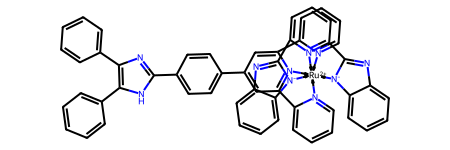

In [7]:
## Two examples:
## 'c1ccc(-c2nc(-c3ccc(-c4cc5-c6ccccn6->[Ru+2]678(<-n9ccccc9-c(c4)n->65)<-n4c(-c5nc6ccccc6[n-]->75)cccc4-c4nc5ccccc5[n-]->84)cc3)[nH]c2-c2ccccc2)cc1'
## 'CC(C)P1(CCP(C(C)C)(C(C)C)->[FeH+]<-12345<-[CH2-]C->2=C->3C->4=C->5C)C(C)C'
smi = 'c1ccc(-c2nc(-c3ccc(-c4cc5-c6ccccn6->[Ru+2]678(<-n9ccccc9-c(c4)n->65)<-n4c(-c5nc6ccccc6[n-]->75)cccc4-c4nc5ccccc5[n-]->84)cc3)[nH]c2-c2ccccc2)cc1'
mol = MolFromSmiles(smi)
AllChem.Compute2DCoords(mol)
mol

In [8]:
## Get ligand mol
tm_indices, tm_atoms = find_all_tms(mol)
emol = EditableMol(Mol(mol))
for idx in sorted(tm_indices, reverse=True):
    emol.RemoveAtom(idx)
tmp = emol.GetMol()
removed = remove_isolated_atoms(tmp)
lsmi = MolToSmiles(removed)
ligands = MolFromSmiles(lsmi)
ligand_list = [MolFromSmiles(n) for n in lsmi.split('.')]
print(f'{len(lsmi.split('.'))} ligands')
print(lsmi)

2 ligands
c1cc(-c2nc3ccccc3[n-]2)nc(-c2nc3ccccc3[n-]2)c1.c1ccc(-c2nc(-c3ccc(-c4cc(-c5ccccn5)nc(-c5ccccn5)c4)cc3)[nH]c2-c2ccccc2)cc1


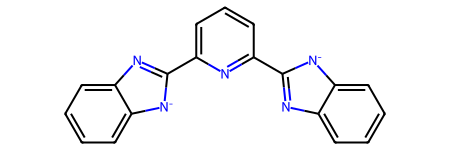

In [9]:
ligand_list[0]

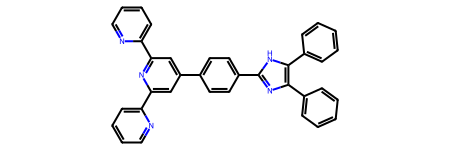

In [10]:
ligand_list[1]

In [11]:
"""
    Ring structures in TMC
    -- initialize the calculation by setting 'includeDativeBonds' to True
"""
sssr = GetSSSR(mol, includeDativeBonds=True)
ri = mol.GetRingInfo()
tmc_ring_sizes = get_all_ring_sizes(mol)
tmc_fused_indices = get_fused_ring_idx(mol)

print(r'Total number of TMC rings:', ri.NumRings())
print(r'Total number of TMC fused rings:', len(tmc_fused_indices))
print(r'Total number of TMC macrocycles:', len([n for n in tmc_ring_sizes if n>7]))

Total number of TMC rings: 16
Total number of TMC fused rings: 12
Total number of TMC macrocycles: 0


In [12]:
"""
    Ligand rings: approach 1
    --> use ligand mol
"""
l_ri = ligands.GetRingInfo()
l_ring_sizes = get_all_ring_sizes(ligands)
l_fused_indices = get_fused_ring_idx(ligands)

print(r'Total number of ligand rings:', l_ri.NumRings())
print(r'Total number of ligand fused rings:', len(l_fused_indices))
print(r'Total number of ligand macrocycles:', len([n for n in l_ring_sizes if n>7]))

Total number of ligand rings: 12
Total number of ligand fused rings: 4
Total number of ligand macrocycles: 0


In [15]:
"""
    Ligand rings: approach 2
    --> use TMC mol but set 'includeDativeBonds' to False in GetSSSR
"""
sssr = GetSSSR(mol, includeDativeBonds=False)
t_ri = mol.GetRingInfo()
t_ring_sizes = get_all_ring_sizes(mol)
t_fused_indices = get_fused_ring_idx(mol)

print(r'Total number of ligand rings:', t_ri.NumRings())
print(r'Total number of ligand fused rings:', len(t_fused_indices))
print(r'Total number of ligand macrocycles:', len([n for n in t_ring_sizes if n>7]))

Total number of ligand rings: 12
Total number of ligand fused rings: 4
Total number of ligand macrocycles: 0


**Note**:  
The first ligand "c1cc(-c2nc3ccccc3[n-]2)nc(-c2nc3ccccc3[n-]2)c1", or *ligand_list[0]*, in example one has four fused rings (two pairs of small rings sharing one bond)

    Copyright ©2025  The Regents of the University of California (Regents). All Rights Reserved. Permission to use, copy, modify, and distribute this software and its documentation for educational, research, and not-for-profit purposes, without fee and without a signed licensing agreement, is hereby granted, provided that the above copyright notice, this paragraph and the following paragraphs appear in all copies, modifications, and distributions. Contact The Office of Technology Licensing, UC Berkeley, 2150 Shattuck Avenue, Suite 408, Berkeley, CA 94704-1362, otl@berkeley.edu.

    Created by John Smith and Mary Doe, Department of Statistics, University of California, Berkeley.

    IN NO EVENT SHALL REGENTS BE LIABLE TO ANY PARTY FOR DIRECT, INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES, INCLUDING LOST PROFITS, ARISING OUT OF THE USE OF THIS SOFTWARE AND ITS DOCUMENTATION, EVEN IF REGENTS HAS BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

    REGENTS SPECIFICALLY DISCLAIMS ANY WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE SOFTWARE AND ACCOMPANYING DOCUMENTATION, IF ANY, PROVIDED HEREUNDER IS PROVIDED "AS IS". REGENTS HAS NO OBLIGATION TO PROVIDE MAINTENANCE, SUPPORT, UPDATES, ENHANCEMENTS, OR MODIFICATIONS